# Vision Transformers

Following along Daniel Bourke's PyTorch Paper Replicating section: https://www.learnpytorch.io/08_pytorch_paper_replicating/

## Setup

In [9]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

In [10]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Data loading

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [11]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [12]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x13f15e150>,
 ['pizza', 'steak', 'sushi'])

In [13]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

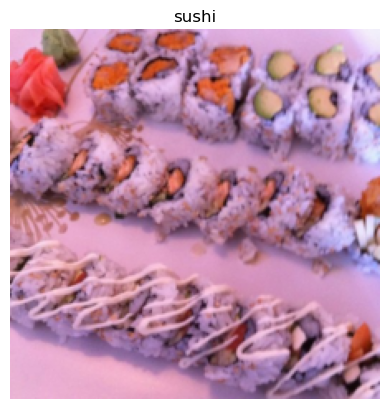

In [14]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Architecture overview

- **Patch + Position Embeddings**: Image -> image patches + position number of the patch
- **Linear Projection of Flattened Patches (Embedded Patches)**: Image patches -> Embeddings
- **Layer Normalization**: Embeddings -> Regularized embeddings 
- **Multi-Head Attention**
- **MLP**: 2 linear layers with a `GELU` non-linearity in between and a `Dropout` after each of them.
- **Transformer Encoder**: LayerNorm -> Multi-Head Attention -> (skip connection from Embedded Patches) -> LayerNorm -> MLP -> (skip connection from the last skip connection)
    - *Skip connection:* Adding the input of the layers to the output of the layers
- **MLP Head**: Output layer, hidden state -> class output

### Essential equations

**First block:**

$$\mathbf{z}_0=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, \quad \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$


Pseudocode:

`x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_n] + [class_token_position, image_patch_1_position, image_patch_2_position, ..., image_patch_n_position]`

- ---

**Second block:**

$$\mathbf{z}_{\ell}^{\prime}=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, \quad \ell=1 \ldots L$$

Pseudocode:

`x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input`

- ---

**Third block:**

$$\mathbf{z}_{\ell}=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \quad \ell=1 \ldots L$$

Pseudocode:

`x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block`

- ---

**Fourth block:**

$$\mathbf{y}=\mathrm{LN}\left(\mathbf{z}_L^0\right)$$

Pseudocode:

`Linear_layer(LN_layer(x_output_MLP_block[0]))`

### Hyperparameters

Replicating ViT-Base... but smaller:

- Layers (# of transformer encoder blocks): 12
- Hidden size $D$ (embedding dimension): 768
- MLP size (# of hidden units in the MLP layers): 3072
- Heads (# of attention heads): 12
- Parameters: 86 M

## Implementation

### Embeddings

- Starting image has size ($H \times W \times C$) (Height, Width, Channels)
- We want to convert it to a sequence of flattened 2D patches of size $N \times (P^2 \dot C)$, where $(P, P)$ is the patch size, and $N = HW \mathbin{/} P^2$ is the number of patches, but also the input sequence length.


So if the patch size is `16` and the image size is `(224, 224, 3)`, we want to go from `(224, 224, 3)` to `((224 * 224) / (16^2), D)` = `(196, 768)`.

In [17]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196
Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


#### Turning an image into patches

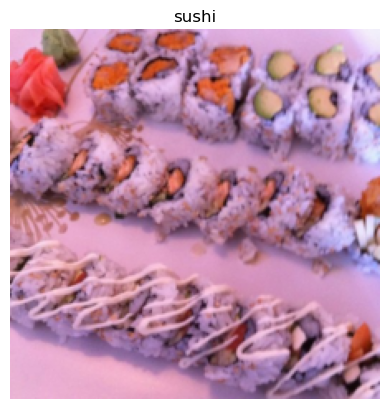

In [18]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [19]:
# STEP THAT HAPPENS ALL THE TIME: Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

Visualizing how we turn just the top row of the image into patched pixels

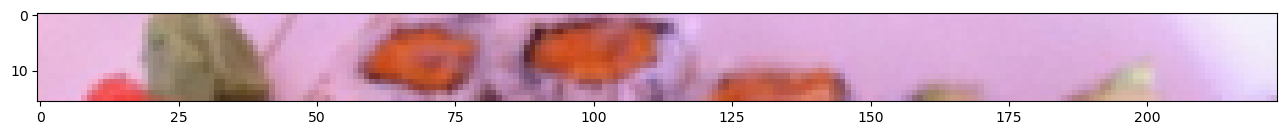

In [20]:
# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


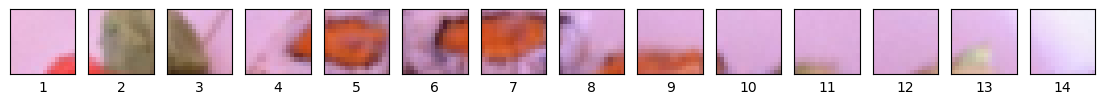

In [26]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size # Because the image is (H x W) / P^2 this is just H^2 / P^2

assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots for the patches
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch: patch + patch_size, :]) # keep height index constant, alter the width index
    
    # Display patch number as the x axis
    axs[i].set_xlabel(i+1)
    
    # Don't display default ticks for either axis
    axs[i].set_xticks([]) 
    axs[i].set_yticks([])

Nice! Now let's do the whole image

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


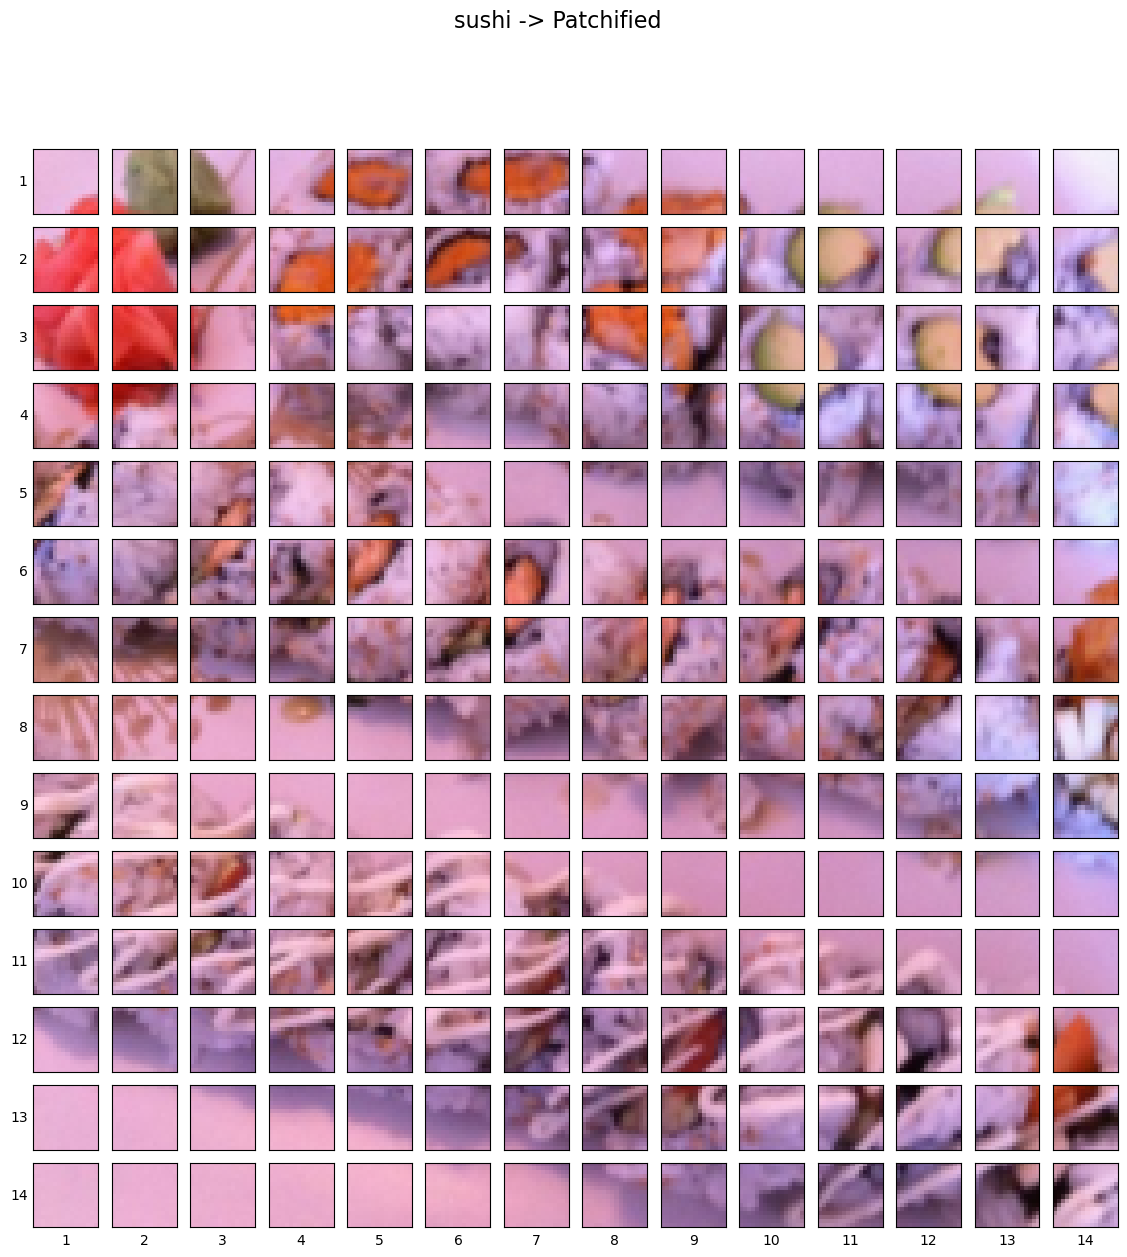

In [31]:
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height: patch_height + patch_size, # iterate through height (rows) 
                                        patch_width: patch_width + patch_size, # iterate through width (columns)
                                       :]) # iterate through all the channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i + 1, rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center")
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
        
# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()